Cleans up storage for https://wandb.ai/usage/data-frugal-learning/student-teacher-v2/runs.

### Load libraries

In [1]:
import os
import pathlib
import sys

import git.repo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wandb
import wandb.apis.public
from tqdm.auto import tqdm
from tqdm.contrib.concurrent import process_map

GIT_ROOT = pathlib.Path(
    str(git.repo.Repo(".", search_parent_directories=True).working_tree_dir)
)
sys.path.append(str(GIT_ROOT))

from src import utils

### Cleanup code

In [2]:
def cleanup(run_id: str, dry_run: bool = False) -> dict[str, int]:
    api = wandb.Api(timeout=60)
    run = api.run(f"data-frugal-learning/student-teacher-v2/{run_id}")

    file_infos = [
        dict(
            name=f.name,
            id=f.id,
            size_bytes=f.size,
        )
        for f in run.files()
    ]

    max_steps = -1
    for fi in file_infos:
        name = fi["name"]
        if name.startswith("media/images/val_imgs_"):
            steps = int(name.split("_")[2])
            max_steps = max(max_steps, steps)


    if max_steps == -1:
        return dict(n_files_deleted=0, bytes_deleted=0)

    ids_to_delete = []
    bytes_deleted = 0
    for fi in file_infos:
        if fi["name"].startswith("media/images"):
            if fi["name"].startswith("media/images/val_imgs_0"):
                continue
            if fi["name"].startswith("media/images/test_imgs_"):
                continue
            if fi["name"].startswith(f"media/images/val_imgs_{max_steps}"):
                continue
            ids_to_delete.append(fi["id"])
            bytes_deleted += fi["size_bytes"]

    if not dry_run:
        mutation = wandb.apis.public.gql(  # type: ignore
            """
            mutation deleteFiles($files: [ID!]!) {
                deleteFiles(input: {
                    files: $files
                }) {
                    success
                }
            }
            """
        )
        api.client.execute(
            mutation,
            variable_values={"files": ids_to_delete},
        )

    return dict(n_files_deleted=len(ids_to_delete), bytes_deleted=bytes_deleted)

### Do large scale cleanup

In [3]:
api = wandb.Api(timeout=30)
runs: list[wandb.apis.public.Run] = api.runs(
    f"data-frugal-learning/student-teacher-v2",
)
len(runs)

res_dicts = process_map(
    cleanup,
    [r.id for r in runs],
    max_workers=10,  # https://docs.wandb.ai/guides/track/limits
    tqdm_class=tqdm,
    chunksize=1,
)
df = pd.DataFrame(res_dicts)

  0%|          | 0/3133 [00:00<?, ?it/s]

1452894
15418.50354 MB


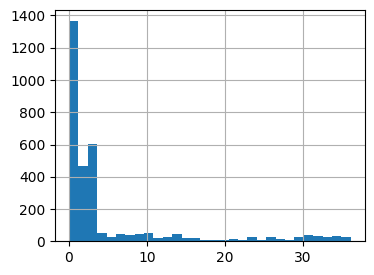

In [4]:
print(df.n_files_deleted.sum())
print(df.bytes_deleted.sum() / 1e6, "MB")
(df.bytes_deleted / 1e6).hist(bins=30, figsize=(4,3));